In [1]:
import numpy as np
import staintools
import torch
from models import StainNet, ResnetGenerator
from PIL import Image 
import matplotlib.pyplot as plt
%matplotlib inline

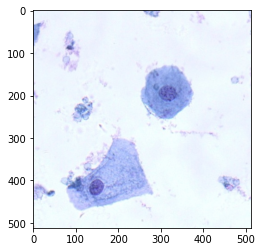

In [2]:
#read source image
img_source=Image.open("assets/3_color_net_neg23570_ori.png")
plt.imshow(img_source)


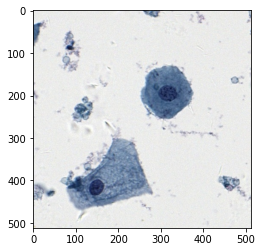

In [3]:
#read target image
img_target=Image.open("assets/3_color_net_neg23570_target.png") 
plt.imshow(img_target)

In [4]:
#load  pretrained StainNet
model_Net = StainNet().cuda()
model_Net.load_state_dict(torch.load("checkpoints/StainNet/StainNet-3x0_best_psnr_layer3_ch32.pth"))

<All keys matched successfully>

In [5]:
def norm(image):
    image = np.array(image).astype(np.float32)
    image = image.transpose((2, 0, 1))
    image = ((image / 255) - 0.5) / 0.5
    image=image[np.newaxis, ...]
    image=torch.from_numpy(image)
    return image

def un_norm(image):
    image = image.cpu().detach().numpy()[0]
    image = ((image * 0.5 + 0.5) * 255).astype(np.uint8).transpose((1,2,0))
    return image


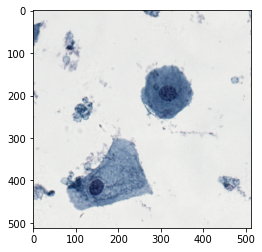

In [6]:
# run normlization
image_net=model_Net(norm(img_source).cuda())
image_net=un_norm(image_net)
plt.imshow(image_net)

In [7]:
#load  pretrained StainGAN
model_GAN = ResnetGenerator(3, 3, ngf=64, norm_layer=torch.nn.InstanceNorm2d, n_blocks=9).cuda().cuda()
model_GAN.load_state_dict(torch.load("checkpoints/StainGAN/latest_net_G_A.pth"))

<All keys matched successfully>

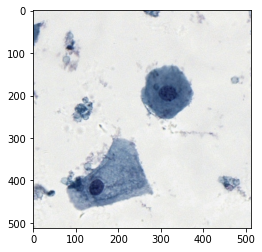

In [8]:
# run normlization
image_gan=model_GAN(norm(img_source).cuda())
image_gan=un_norm(image_gan)
plt.imshow(image_gan)

reinhard


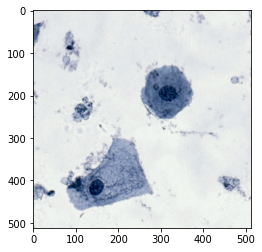

In [9]:
# run reinhard normlization
print("reinhard")
normalizer = staintools.ReinhardColorNormalizer()
normalizer.fit(np.array(img_target))
reinhard_normalized = normalizer.transform(np.array(img_source))
plt.imshow(reinhard_normalized)

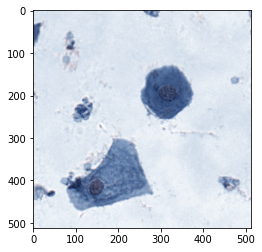

In [10]:
# run macenko normlization
normalizer = staintools.StainNormalizer(method="macenko")
normalizer.fit(np.array(img_target))
macenko_normalized = normalizer.transform(np.array(img_source))
plt.imshow(macenko_normalized)

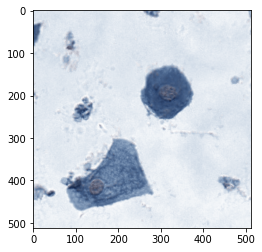

In [11]:
# run vahadane normlization
normalizer = staintools.StainNormalizer(method="vahadane")
normalizer.fit(np.array(img_target))
vahadane_normalized = normalizer.transform(np.array(img_source))
plt.imshow(vahadane_normalized)